# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [2]:
import pandas as pd 
import numpy as np 
import plotly.express as px
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm

## Read data 

In [7]:

dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



# Create basic choropleth map
fig = px.choropleth(dat, locations='code', color='dem', hover_name='code',
                    projection='natural earth', title='GDP per Capita by Country')
fig.show()

countries = ['ARG', 'AUS', 'AUT', 'BEL', 'BEN', 'BOL', 'BRA', 'CAF', 'CHL', 'CHN', 'CIV', 'CMR', 'COL', 'CRI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'FIN', 'FRA', 'GAB', 'GBR', 'GHA', 'GMB', 'GRC', 'GTM', 'GUY', 'HND', 'IDN', 'IND', 'IRL', 'IRN', 'ITA', 'JAM', 'KEN', 'KOR', 'LKA', 'MAR', 'MEX', 'MLI', 'MMR', 'MRT', 'MYS', 'NER', 'NIC', 'NLD', 'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'PRT', 'PRY', 'RWA', 'SAU', 'SEN', 'SLE', 'SLV', 'SWE', 'TGO', 'THA', 'TUN', 'TUR', 'URY', 'USA', 'ZAF', 'ZMB', 'ZWE']

subset = dat[dat['code'].isin(countries)].copy()
subset = subset.dropna(subset=['gdp_pc_now'])  # choose your color field

# Create basic choropleth map
fig = px.choropleth(subset, locations='code', color='gdp_growth', hover_name='code',
                    projection='natural earth', title='GDP per Capita by Country')
fig.show()
fig.write_image(
    "/Users/jensbyrialssonbjorst/AME/AME_2025/AME_2025/Assignments/Project 2/gdp_map.html",
    scale=2,
    width=1600,
    height=900
)
dat

The data contains 214 rows (countries) and 85 columns (variables).


ValueError: Invalid format 'html'.
    Supported formats: ['png', 'jpg', 'jpeg', 'webp', 'svg', 'pdf', 'eps', 'json']

# Descriptive plots

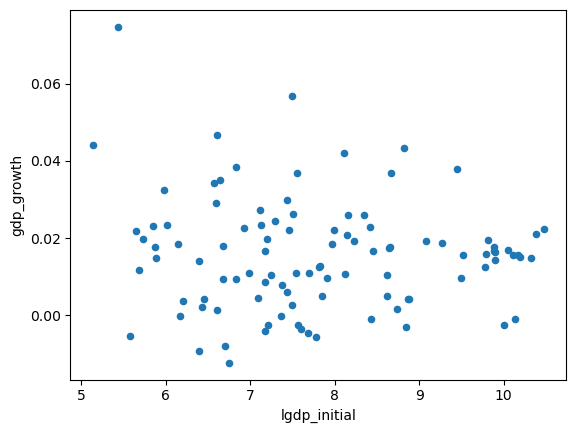

In [58]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

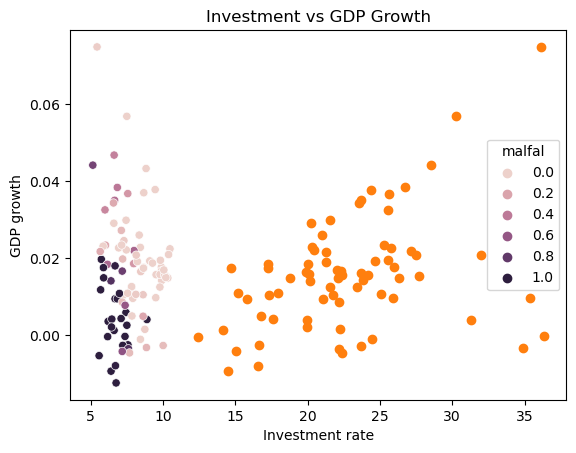

In [ ]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');


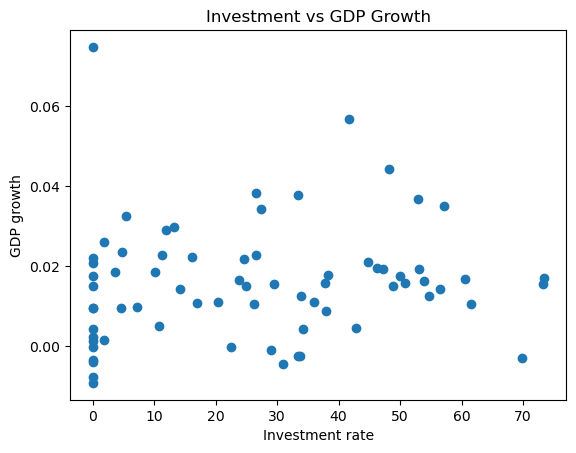

    code  investment_rate  gdp_growth
153  SUR        40.461367    0.004948
187  ZMB        36.330155   -0.000287
121  NGA        36.190952    0.005931
31   CHN        36.118376    0.074763
47   DZA        35.401038    0.009580
77   IRN        34.918004   -0.003168
34   COG        33.978302    0.002609
129  PAN        31.964689    0.020793
57   GAB        31.310758    0.004096
146  SGP        31.056954    0.043240
158  SYC        30.994459    0.025878
26   BWA        30.542293    0.046723
91   KOR        30.232281    0.056771
89   KIR        29.055895   -0.005606
111  MMR        28.522693    0.044116
7    AUS        27.672347    0.015481
124  NOR        27.481677    0.020941
68   GUY        27.125898    0.021970
163  THA        26.737476    0.038335
156  SWE        26.336359    0.014982


In [117]:
plt.scatter(subset['marketref'], subset['gdp_growth'])
plt.xlabel('Investment rate')
plt.ylabel('GDP growth')
plt.title('Investment vs GDP Growth')
plt.show()

top_n = 20  # adjust as needed
summary = (
    dat[['code', 'investment_rate', 'gdp_growth']]
    .dropna(subset=['investment_rate', 'gdp_growth'])
    .sort_values('investment_rate', ascending=False)
    .head(top_n)
)

print(summary)

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [60]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [61]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [75]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)
head.(I)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

SyntaxError: invalid syntax (82808403.py, line 3)

# Adding more controls

In [ ]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values

y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
print(K)
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

27


In [70]:
vs = vv_all['geography'] + vv_all['religion'] + vv_all['institutions']
vs = [v for v in vs if v != 'demBMR'] 
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%


# add const. (unless this breaks the rank condition)
#oo = np.ones((I.sum(),1))
#X = np.hstack([X, oo])
#xs.append('constant') # we put it in as the last element

df_X = dat.loc[I, xs].copy()
dup_cols = df_X.T.duplicated()
print("Duplicate columns:", df_X.columns[dup_cols.values].tolist())
# check the rank condition
K = X.shape[1]
print(K)
#assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'




Duplicate columns: []
31


In [71]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


ValueError: Length of values (27) does not match length of index (31)

In [72]:
def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

X_tilde=standardize(X)

# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num=50)

coefs=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(X_tilde,y) 
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

In [73]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    coefs (array-like): The estimated coefficients for each penalty value.
    legends (list): The labels for each coefficient estimate.
    vlines (dict, optional): A dictionary of vertical lines to add to the plot. The keys are the names of the lines and the values are the penalty values where the lines should be drawn.
    
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    ax.set_ylim(-2,1)
    # Plot coefficients as a function of the penalty parameter
    ax.plot(penalty_grid, coefs)

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title('Lasso Path')

    # Add legends
    lgd=ax.legend(legends,loc=(1.04,0))
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,-80000,name,rotation=90)

    
    # Display plot
    plt.show()
    plt.close()


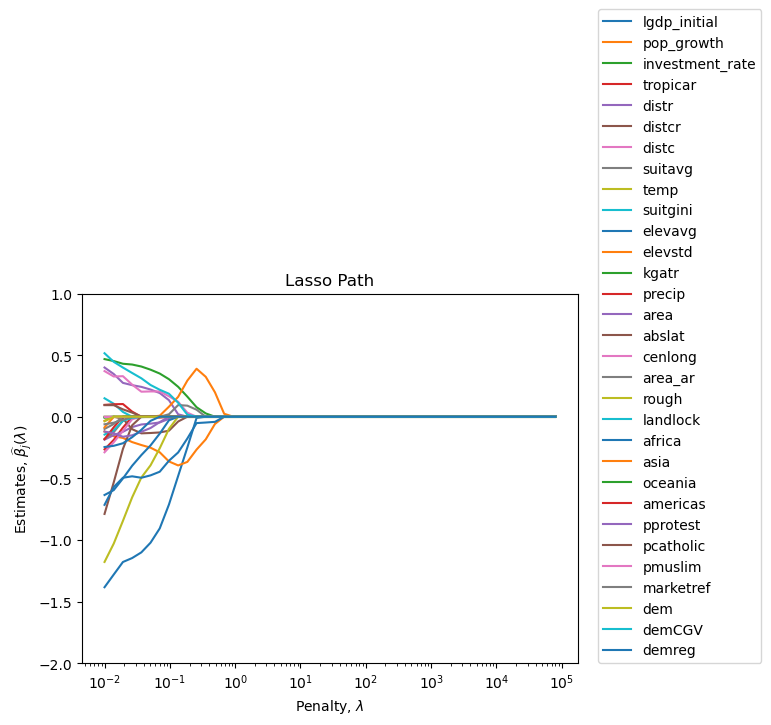

In [74]:
plot_lasso_path(penalty_grid, coefs, xs)